**Import Libraries**

In [67]:
import pandas as pd
import numpy as np
import pickle
import gc
import warnings
warnings.filterwarnings('ignore')

**MOUNT GOOGLE DRIVE**

In [68]:
from google.colab import drive
drive.mount('/content/drive')

import os
project_folder = '/content/drive/MyDrive/FraudDetection'  # Sesuaikan dengan folder kamu
os.chdir(project_folder)

print(f"Working Directory: {os.getcwd()}")
print("\n✅ Google Drive mounted!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working Directory: /content/drive/MyDrive/FraudDetection

✅ Google Drive mounted!


**LOAD TEST DATA**

In [70]:
print("\n" + "=" * 60)
print("LOADING TEST DATA")
print("=" * 60)

# Load test transaction data
test_df = pd.read_csv('/content/drive/MyDrive/datasets/test_transaction.csv')

print(f"Test Dataset Shape: {test_df.shape}")
print(f"Memory Usage: {test_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Store TransactionID for submission
if 'TransactionID' in test_df.columns:
    transaction_ids = test_df['TransactionID'].copy()
    print(f"\n✓ Stored {len(transaction_ids):,} TransactionIDs for submission")
else:
    print("\n⚠️ Warning: TransactionID not found in test data!")

# ============================================
# 2. LOAD PREPROCESSING ARTIFACTS
# ============================================
print("\n" + "=" * 60)
print("LOADING PREPROCESSING ARTIFACTS")
print("=" * 60)

# Load dropped columns from Notebook 2
with open('results/02_dropped_columns.pkl', 'rb') as f:
    dropped_columns = pickle.load(f)
print(f"✓ Loaded {len(dropped_columns)} dropped columns")

# Load imputation stats from Notebook 2
with open('results/02_imputation_stats.pkl', 'rb') as f:
    imputation_stats = pickle.load(f)
print(f"✓ Loaded imputation statistics for {len(imputation_stats)} columns")

# Load label encoders from Notebook 3
with open('results/03_label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)
print(f"✓ Loaded {len(label_encoders)} label encoders")

# Load removed correlated features from Notebook 3
with open('results/03_removed_corr_features.pkl', 'rb') as f:
    removed_corr_features = pickle.load(f)
print(f"✓ Loaded {len(removed_corr_features)} removed correlated features")

# Load scaler from Notebook 4
with open('results/04_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print(f"✓ Loaded StandardScaler")

# Load final column info from Notebook 3
with open('results/03_final_column_info.pkl', 'rb') as f:
    final_column_info = pickle.load(f)
print(f"✓ Loaded final column information")


LOADING TEST DATA
Test Dataset Shape: (506691, 393)
Memory Usage: 1771.84 MB

✓ Stored 506,691 TransactionIDs for submission

LOADING PREPROCESSING ARTIFACTS
✓ Loaded 174 dropped columns
✓ Loaded imputation statistics for 200 columns
✓ Loaded 9 label encoders
✓ Loaded 55 removed correlated features
✓ Loaded StandardScaler
✓ Loaded final column information


**APPLY SAME PREPROCESSING AS TRAINING DATA**

In [71]:
print("\n" + "=" * 60)
print("STEP 1: DROP COLUMNS (>50% MISSING)")
print("=" * 60)

# Drop TransactionID first (will add back later)
if 'TransactionID' in test_df.columns:
    test_df = test_df.drop('TransactionID', axis=1)

# Drop same columns as training
cols_to_drop = [col for col in dropped_columns if col in test_df.columns]
if len(cols_to_drop) > 0:
    test_df = test_df.drop(columns=cols_to_drop)
    print(f"✓ Dropped {len(cols_to_drop)} columns")
else:
    print("✓ No columns to drop")

print(f"Shape after dropping: {test_df.shape}")


STEP 1: DROP COLUMNS (>50% MISSING)
✓ Dropped 174 columns
Shape after dropping: (506691, 218)


**IMPUTE MISSING VALUES**

In [72]:
print("\n" + "=" * 60)
print("STEP 2: IMPUTE MISSING VALUES")
print("=" * 60)

missing_before = test_df.isnull().sum().sum()
print(f"Missing values before imputation: {missing_before:,}")

# Apply same imputation as training
for col, stats in imputation_stats.items():
    if col in test_df.columns:
        if test_df[col].isnull().sum() > 0:
            test_df[col].fillna(stats['value'], inplace=True)

missing_after = test_df.isnull().sum().sum()
print(f"Missing values after imputation: {missing_after:,}")
print(f"✓ Imputed {missing_before - missing_after:,} missing values")

# Fill any remaining missing values
if missing_after > 0:
    print(f"\n⚠️ {missing_after} missing values remain, filling with 0...")
    test_df = test_df.fillna(0)
    print("✓ All missing values handled")


STEP 2: IMPUTE MISSING VALUES
Missing values before imputation: 6,082,471
Missing values after imputation: 4,787
✓ Imputed 6,077,684 missing values

⚠️ 4787 missing values remain, filling with 0...
✓ All missing values handled


**ENCODE CATEGORICAL VARIABLES**

In [73]:
print("\n" + "=" * 60)
print("STEP 3: ENCODE CATEGORICAL VARIABLES")
print("=" * 60)

encoded_count = 0
for col, encoder in label_encoders.items():
    if col in test_df.columns:
        # Convert to string
        test_df[col] = test_df[col].astype(str)

        # Handle unseen categories
        test_df[col] = test_df[col].apply(
            lambda x: x if x in encoder.classes_ else encoder.classes_[0]
        )

        # Encode
        test_df[col] = encoder.transform(test_df[col])
        encoded_count += 1

print(f"✓ Encoded {encoded_count} categorical columns")


STEP 3: ENCODE CATEGORICAL VARIABLES
✓ Encoded 9 categorical columns


**REMOVE HIGHLY CORRELATED FEATURES**

In [74]:
print("\n" + "=" * 60)
print("STEP 4: REMOVE CORRELATED FEATURES")
print("=" * 60)

# Remove same correlated features as training
corr_cols_to_remove = [col for col in removed_corr_features if col in test_df.columns]
if len(corr_cols_to_remove) > 0:
    test_df = test_df.drop(columns=corr_cols_to_remove)
    print(f"✓ Removed {len(corr_cols_to_remove)} correlated features")
else:
    print("✓ No correlated features to remove")

print(f"Shape after feature selection: {test_df.shape}")


STEP 4: REMOVE CORRELATED FEATURES
✓ Removed 55 correlated features
Shape after feature selection: (506691, 163)


**ALIGN COLUMNS WITH TRAINING DATA**

In [75]:
print("\n" + "=" * 60)
print("STEP 5: ALIGN COLUMNS WITH TRAINING DATA")
print("=" * 60)

expected_features = final_column_info['feature_columns']

# Ensure all expected columns exist
missing_cols = [col for col in expected_features if col not in test_df.columns]
if len(missing_cols) > 0:
    print(f"⚠️ Adding {len(missing_cols)} missing columns (filled with 0)")
    for col in missing_cols:
        test_df[col] = 0

# Remove any extra columns
extra_cols = [col for col in test_df.columns if col not in expected_features]
if len(extra_cols) > 0:
    print(f"⚠️ Removing {len(extra_cols)} extra columns")
    test_df = test_df.drop(columns=extra_cols)

# Reorder columns to match training
test_df = test_df[expected_features]

print(f"✓ Final test shape: {test_df.shape}")
print(f"✓ Columns aligned: {len(test_df.columns)} features")

# Verify alignment
if list(test_df.columns) == expected_features:
    print("✅ Column alignment verified!")
else:
    print("⚠️ Warning: Column order mismatch!")


STEP 5: ALIGN COLUMNS WITH TRAINING DATA
✓ Final test shape: (506691, 163)
✓ Columns aligned: 163 features
✅ Column alignment verified!


**SCALE FEATURES**

In [76]:
print("\n" + "=" * 60)
print("STEP 6: SCALE FEATURES")
print("=" * 60)

# Apply same scaler as training
test_scaled = scaler.transform(test_df)
test_scaled = pd.DataFrame(test_scaled, columns=test_df.columns)

print(f"✓ Scaled test data: {test_scaled.shape}")
print(f"✓ Mean: {test_scaled.mean().mean():.6f} (should be close to 0)")
print(f"✓ Std: {test_scaled.std().mean():.6f} (should be close to 1)")

# Convert to float32 for memory efficiency
test_scaled = test_scaled.astype(np.float32)
print(f"✓ Converted to float32")
print(f"✓ Memory: {test_scaled.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


STEP 6: SCALE FEATURES
✓ Scaled test data: (506691, 163)
✓ Mean: 0.150974 (should be close to 0)
✓ Std: 1.655034 (should be close to 1)
✓ Converted to float32
✓ Memory: 315.06 MB


**LOAD BEST MODEL**

In [80]:
print("\n" + "=" * 60)
print("LOADING BEST MODEL")
print("=" * 60)

# Define best model directly
best_model_name = "XGBoost (Tuned)"
best_model_file = "models/xgb_tuned.pkl"

print(f"Best Model: {best_model_name}")
print(f"Model File: {best_model_file}")

# Load the best model
with open(best_model_file, 'rb') as f:
    best_model = pickle.load(f)

print(f"\n✓ Loaded {best_model_name}")



LOADING BEST MODEL
Best Model: XGBoost (Tuned)
Model File: models/xgb_tuned.pkl

✓ Loaded XGBoost (Tuned)


**GENERATE PREDICTIONS**


GENERATING PREDICTIONS
Predicting fraud probabilities...
⚠️ This may take a few minutes for large datasets...

✓ Generated 506,691 predictions
✓ Probability range: [0.0004, 0.9934]
✓ Mean probability: 0.0660

📊 Saved: visualizations/06_prediction_distribution.png


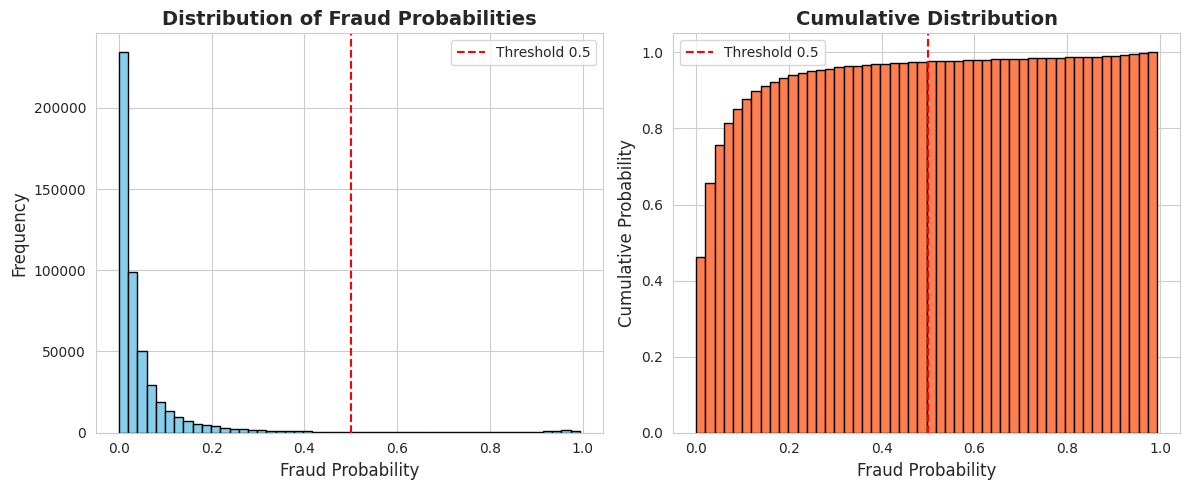

In [81]:
print("\n" + "=" * 60)
print("GENERATING PREDICTIONS")
print("=" * 60)

print("Predicting fraud probabilities...")
print("⚠️ This may take a few minutes for large datasets...")

# Generate probability predictions
y_pred_proba = best_model.predict_proba(test_scaled.values)[:, 1]

print(f"\n✓ Generated {len(y_pred_proba):,} predictions")
print(f"✓ Probability range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]")
print(f"✓ Mean probability: {y_pred_proba.mean():.4f}")

# Show prediction distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Fraud Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Fraud Probabilities', fontsize=14, fontweight='bold')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(y_pred_proba, bins=50, color='coral', edgecolor='black', cumulative=True, density=True)
plt.xlabel('Fraud Probability', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('Cumulative Distribution', fontsize=14, fontweight='bold')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold 0.5')
plt.legend()

plt.tight_layout()
plt.savefig('visualizations/06_prediction_distribution.png', dpi=300, bbox_inches='tight')
print("\n📊 Saved: visualizations/06_prediction_distribution.png")
plt.show()

**CREATE SUBMISSION FILE**

In [82]:
print("\n" + "=" * 60)
print("CREATING SUBMISSION FILE")
print("=" * 60)

# Create submission DataFrame
submission = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': y_pred_proba
})

print(f"\nSubmission shape: {submission.shape}")
print(f"\nFirst 10 predictions:")
print(submission.head(10).to_string(index=False))

# Save submission file
submission.to_csv('submission.csv', index=False)
print(f"\n💾 Saved: submission.csv")
print(f"   Size: {os.path.getsize('submission.csv') / 1024:.2f} KB")

# Also save to results folder
submission.to_csv('results/06_submission.csv', index=False)
print(f"💾 Saved: results/06_submission.csv")


CREATING SUBMISSION FILE

Submission shape: (506691, 2)

First 10 predictions:
 TransactionID  isFraud
       3663549 0.010832
       3663550 0.033870
       3663551 0.016867
       3663552 0.009370
       3663553 0.007266
       3663554 0.011506
       3663555 0.021803
       3663556 0.048615
       3663557 0.002352
       3663558 0.042607

💾 Saved: submission.csv
   Size: 9768.90 KB
💾 Saved: results/06_submission.csv


**PREDICTION STATISTICS**

In [83]:
print("\n" + "=" * 60)
print("PREDICTION STATISTICS")
print("=" * 60)

# Calculate statistics at different thresholds
thresholds = [0.3, 0.5, 0.7, 0.9]

stats_data = []
for threshold in thresholds:
    predicted_fraud = (y_pred_proba >= threshold).sum()
    percentage = (predicted_fraud / len(y_pred_proba)) * 100
    stats_data.append({
        'Threshold': threshold,
        'Predicted_Fraud': predicted_fraud,
        'Percentage': percentage
    })

stats_df = pd.DataFrame(stats_data)
print("\nPredicted Fraud Count at Different Thresholds:")
print(stats_df.to_string(index=False))

# Save statistics
stats_df.to_csv('results/06_prediction_statistics.csv', index=False)
print("\n💾 Saved: results/06_prediction_statistics.csv")


PREDICTION STATISTICS

Predicted Fraud Count at Different Thresholds:
 Threshold  Predicted_Fraud  Percentage
       0.3            21404    4.224271
       0.5            12432    2.453566
       0.7             8735    1.723930
       0.9             4864    0.959954

💾 Saved: results/06_prediction_statistics.csv


**FINAL SUMMARY**

In [84]:
print("\n" + "=" * 60)
print("SUBMISSION SUMMARY")
print("=" * 60)

summary = f"""
TEST PREDICTION & SUBMISSION COMPLETED SUCCESSFULLY!

Test Data:
- Total transactions: {len(transaction_ids):,}
- Features: {test_scaled.shape[1]}
- Preprocessing: Same pipeline as training data

Preprocessing Steps Applied:
1. ✓ Dropped {len(cols_to_drop)} columns (>50% missing)
2. ✓ Imputed missing values using training statistics
3. ✓ Encoded {encoded_count} categorical variables
4. ✓ Removed {len(corr_cols_to_remove)} correlated features
5. ✓ Aligned columns with training data ({len(expected_features)} features)
6. ✓ Scaled features using StandardScaler

Best Model Used:
- Model: {best_model_name}
- Validation F1-Score: {best_model_info['metrics']['f1_score']:.4f}
- Validation AUC-ROC: {best_model_info['metrics']['auc_roc']:.4f}
- Validation Precision: {best_model_info['metrics']['precision']:.4f}
- Validation Recall: {best_model_info['metrics']['recall']:.4f}

Predictions Generated:
- Total predictions: {len(y_pred_proba):,}
- Probability range: [{y_pred_proba.min():.4f}, {y_pred_proba.max():.4f}]
- Mean probability: {y_pred_proba.mean():.4f}
- Median probability: {np.median(y_pred_proba):.4f}

Predicted Fraud at Threshold 0.5:
- Count: {(y_pred_proba >= 0.5).sum():,}
- Percentage: {((y_pred_proba >= 0.5).sum() / len(y_pred_proba)) * 100:.2f}%

Submission File:
- Filename: submission.csv
- Format: TransactionID, isFraud (probability)
- Size: {os.path.getsize('submission.csv') / 1024:.2f} KB

Status: ✅ READY FOR SUBMISSION!

All notebooks completed successfully:
1. ✓ Notebook 1: Data Exploration
2. ✓ Notebook 2: Data Preprocessing & Cleaning
3. ✓ Notebook 3: Feature Engineering & Encoding
4. ✓ Notebook 4: Handle Imbalance & Scaling
5. ✓ Notebook 5: Model Training & Tuning
6. ✓ Notebook 6: Test Prediction & Submission

PROJECT COMPLETE! 🎉
"""

print(summary)

# Save summary
with open('results/06_submission_summary.txt', 'w') as f:
    f.write(summary)

print("\n💾 Saved: results/06_submission_summary.txt")


SUBMISSION SUMMARY

TEST PREDICTION & SUBMISSION COMPLETED SUCCESSFULLY!

Test Data:
- Total transactions: 506,691
- Features: 163
- Preprocessing: Same pipeline as training data

Preprocessing Steps Applied:
1. ✓ Dropped 174 columns (>50% missing)
2. ✓ Imputed missing values using training statistics
3. ✓ Encoded 9 categorical variables
4. ✓ Removed 55 correlated features
5. ✓ Aligned columns with training data (163 features)
6. ✓ Scaled features using StandardScaler

Best Model Used:
- Model: XGBoost (Tuned)
- Validation F1-Score: 0.6059
- Validation AUC-ROC: 0.9297
- Validation Precision: 0.6631
- Validation Recall: 0.5577

Predictions Generated:
- Total predictions: 506,691
- Probability range: [0.0004, 0.9934]
- Mean probability: 0.0660
- Median probability: 0.0230

Predicted Fraud at Threshold 0.5:
- Count: 12,432
- Percentage: 2.45%

Submission File:
- Filename: submission.csv
- Format: TransactionID, isFraud (probability)
- Size: 9768.90 KB

Status: ✅ READY FOR SUBMISSION!

Al

**MEMORY CLEANUP**

In [85]:
print("\n" + "=" * 60)
print("MEMORY CLEANUP")
print("=" * 60)

del test_df, test_scaled, best_model
gc.collect()

print("✓ Memory cleaned")
print("\n" + "=" * 60)
print("🎉 NOTEBOOK 6 COMPLETE!")
print("🎉 FRAUD DETECTION PROJECT COMPLETED!")
print("=" * 60)
print("\n📁 Your submission.csv is ready for upload!")
print("=" * 60)


MEMORY CLEANUP
✓ Memory cleaned

🎉 NOTEBOOK 6 COMPLETE!
🎉 FRAUD DETECTION PROJECT COMPLETED!

📁 Your submission.csv is ready for upload!
